In [5]:
import gym
import numpy as np 
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input
from keras.layers.merge import Add, Multiply
from keras.optimizers import Adam
import keras.backend as K

import tensorflow as tf

import random
from collections import deque

# determines how to assign values to each state, i.e. takes the state
# and action (two-input model) and determines the corresponding value
class ActorCritic:
	def __init__(self, env, sess):
		self.env  = env
		self.sess = sess

		self.learning_rate = 0.001
		self.epsilon = 1.0
		self.epsilon_decay = .995
		self.gamma = .95
		self.tau   = .125

		# ===================================================================== #
		#                               Actor Model                             #
		# Chain rule: find the gradient of chaging the actor network params in  #
		# getting closest to the final value network predictions, i.e. de/dA    #
		# Calculate de/dA as = de/dC * dC/dA, where e is error, C critic, A act #
		# ===================================================================== #

		self.memory = deque(maxlen=2000)
		self.actor_state_input, self.actor_model = self.create_actor_model()
		_, self.target_actor_model = self.create_actor_model()

		self.actor_critic_grad = tf.placeholder(tf.float32, 
			[None, self.env.action_space.shape[0]]) # where we will feed de/dC (from critic)
		
		actor_model_weights = self.actor_model.trainable_weights
		self.actor_grads = tf.gradients(self.actor_model.output, 
			actor_model_weights, -self.actor_critic_grad) # dC/dA (from actor)
		grads = zip(self.actor_grads, actor_model_weights)
		self.optimize = tf.train.AdamOptimizer(self.learning_rate).apply_gradients(grads)

		# ===================================================================== #
		#                              Critic Model                             #
		# ===================================================================== #		

		self.critic_state_input, self.critic_action_input, \
			self.critic_model = self.create_critic_model()
		_, _, self.target_critic_model = self.create_critic_model()

		self.critic_grads = tf.gradients(self.critic_model.output, 
			self.critic_action_input) # where we calcaulte de/dC for feeding above
		
		# Initialize for later gradient calculations
		self.sess.run(tf.initialize_all_variables())

	# ========================================================================= #
	#                              Model Definitions                            #
	# ========================================================================= #

	def create_actor_model(self):
		state_input = Input(shape=self.env.observation_space.shape)
		h1 = Dense(24, activation='relu')(state_input)
		h2 = Dense(48, activation='relu')(h1)
		h3 = Dense(24, activation='relu')(h2)
		output = Dense(self.env.action_space.shape[0], activation='relu')(h3)
		
		model = Model(input=state_input, output=output)
		adam  = Adam(lr=0.001)
		model.compile(loss="mse", optimizer=adam)
		return state_input, model

	def create_critic_model(self):
		state_input = Input(shape=self.env.observation_space.shape)
		state_h1 = Dense(24, activation='relu')(state_input)
		state_h2 = Dense(48)(state_h1)
		
		action_input = Input(shape=self.env.action_space.shape)
		action_h1    = Dense(48)(action_input)
		
		merged    = Add()([state_h2, action_h1])
		merged_h1 = Dense(24, activation='relu')(merged)
		output = Dense(1, activation='relu')(merged_h1)
		model  = Model(input=[state_input,action_input], output=output)
		
		adam  = Adam(lr=0.001)
		model.compile(loss="mse", optimizer=adam)
		return state_input, action_input, model

	# ========================================================================= #
	#                               Model Training                              #
	# ========================================================================= #

	def remember(self, cur_state, action, reward, new_state, done):
		self.memory.append([cur_state, action, reward, new_state, done])

	def _train_actor(self, samples):
		for sample in samples:
			cur_state, action, reward, new_state, _ = sample
			predicted_action = self.actor_model.predict(cur_state)
			grads = self.sess.run(self.critic_grads, feed_dict={
				self.critic_state_input:  cur_state,
				self.critic_action_input: predicted_action
			})[0]

			self.sess.run(self.optimize, feed_dict={
				self.actor_state_input: cur_state,
				self.actor_critic_grad: grads
			})
            
	def _train_critic(self, samples):
		for sample in samples:
			cur_state, action, reward, new_state, done = sample
			if not done:
				target_action = self.target_actor_model.predict(new_state)
				future_reward = self.target_critic_model.predict(
					[new_state, target_action])[0][0]
				reward += self.gamma * future_reward
			self.critic_model.fit([cur_state, action], reward, verbose=0)
		
	def train(self):
		batch_size = 32
		if len(self.memory) < batch_size:
			return

		rewards = []
		samples = random.sample(self.memory, batch_size)
		self._train_critic(samples)
		self._train_actor(samples)

	# ========================================================================= #
	#                         Target Model Updating                             #
	# ========================================================================= #

	def _update_actor_target(self):
		actor_model_weights  = self.actor_model.get_weights()
		actor_target_weights = self.target_critic_model.get_weights()
		
		for i in range(len(actor_target_weights)):
			actor_target_weights[i] = actor_model_weights[i]
		self.target_critic_model.set_weights(actor_target_weights)

	def _update_critic_target(self):
		critic_model_weights  = self.critic_model.get_weights()
		critic_target_weights = self.critic_target_model.get_weights()
		
		for i in range(len(critic_target_weights)):
			critic_target_weights[i] = critic_model_weights[i]
		self.critic_target_model.set_weights(critic_target_weights)		

	def update_target(self):
		self._update_actor_target()
		self._update_critic_target()

	# ========================================================================= #
	#                              Model Predictions                            #
	# ========================================================================= #

	def act(self, cur_state):
		self.epsilon *= self.epsilon_decay
		if np.random.random() < self.epsilon:
			return self.env.action_space.sample()
		return self.actor_model.predict(cur_state)

def main():
	sess = tf.Session()
	K.set_session(sess)
	env = gym.make("Pendulum-v0")
	actor_critic = ActorCritic(env, sess)

	num_trials = 10000
	trial_len  = 500

	cur_state = env.reset()
	action = env.action_space.sample()
	while True:
        for _ in range(500):
            env.render()
            cur_state = cur_state.reshape((1, env.observation_space.shape[0]))
            action = actor_critic.act(cur_state)
            action = action.reshape((1, env.action_space.shape[0]))

            new_state, reward, done, _ = env.step(action)
            new_state = new_state.reshape((1, env.observation_space.shape[0]))

            actor_critic.remember(cur_state, action, reward, new_state, done)
            actor_critic.train()

            cur_state = new_state

if __name__ == "__main__":
	main()

TabError: inconsistent use of tabs and spaces in indentation (<ipython-input-5-db8832b864c9>, line 181)

In [35]:
def inchange(a,b):
    if b-a == 1:
        return [1,1]
    elif b-a == 3:
        return [1,3]
    elif b-a == 4:
        return [1,4]
    else:
        l = [[b-1,1],[b-3,3],[b-4,4]]
        a = sorted(l,reverse = False,key = lambda x: x[0])
#         print(a)
        return a[0]

def mini(l):
    a = sorted(l,reverse=False,key = lambda x: x[0])
    
    return a[0]
        

def change(n):
    # 1 3 4 demo
    a = [0]*(n+1)
    b=0
    for x in range(1,len(a)):
        c,r = mini([inchange(b,x),inchange(1,x),inchange(3,x),inchange(4,x)])
        b=x
        print(c,r)
        
    
    

In [36]:
change(9)

-3 4
-2 4
-1 4
0 4
1 1
1 1
1 1
1 1
1 1


In [37]:
import matplotlib.pyplot as plt 

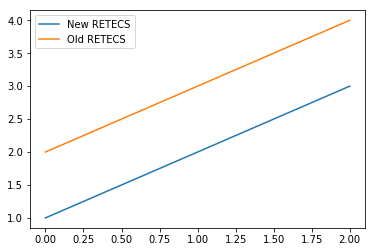

In [39]:

plt.plot([1,2,3])
plt.plot([2,3,4])
plt.legend(['New RETECS','Old RETECS'])
plt.show()

In [128]:
def check(l,a):
    c=[]
    if a%2 == 0:
        c.append([l[int(a/2)][0],2])
        (l[int(a/2)][1]).append(2)
    if a%3 ==0:
        c.append([l[int(a/3)][0],3])
        (l[int(a/3)][1]).append(3)
    if a-1 >=0:
        c.append([l[a-1][0],1])
        (l[a-1][1]).append(1)
    
    d = sorted(c,reverse=False,key=lambda x: x[0])
    
    return d[0]
    
        

def change(n):
    #1 3 4 coins 
    l = [0,[]]*(n+1)
    for x in range(1,n+1):
        l[x][0] = check(l,x)+1
    print(l)
    

In [129]:
check([[1,[]],[2,[]],[1,[]],[1,[]]],4)

[1, 2]

In [130]:
change(5)

TypeError: 'int' object is not subscriptable

In [68]:
1%3

1

In [51]:
class stack(object):
    def __init__(self):
        self.list = []
    def add(self,x):
        self.list.append(x)
    def get(self):
        if len(self.list)>0:
            return self.list.pop()
        else:
            return None
    def length(self):
        return len(self.list)
    def pp(self):
        print(self.list)
        

In [52]:
def alls(x,l):
    for y in l:
        if y == x:
            return True
    return False

In [76]:
def clean(x):
    l = ['[',']','{','}','(',')']
    for y in l:
        if x == y:
            return True 
    return False
            
        

In [92]:
def final(l):
    sta = stack()
    for x in range(len(l)):
        if l[x] == '[' or l[x] == '{' or l[x] == '(' and clean(l[x]):
            sta.add(l[x])
            
        elif clean(l[x]):
            if abs(ord(l[x]) - ord(sta.get())) < 3  :
                pass
            else:
                return x+1    
        else:
            pass
    if sta.length():
        return sta.length()
    else:
        print('Success')
        

In [101]:
final('[]')

Success


In [35]:
a.get()

In [41]:
l = ['[',']','{','}','(',')']

In [60]:
for x in l:
    print(ord(x))

91
93
123
125
40
41


In [213]:
class stack(object):
    def __init__(self):
        self.list = []
    def add(self,x):
        self.list.append(x)
    def get(self):
      
        self.list.pop()
        print(self.list)
    def length(self):
        return len(self.list)
    def pp(self):
        print(self.list)
    
    def maxm(self):
        return (max(self.list))
        



In [221]:
def ans (ll):
    r=[]
    for l in ll:
        if len(l)>1:
            a,b = l
            if a == 'push':
                r.append(int(b))
        else:
            a = l[0]

            if a == 'pop':
                r.pop()
            else:
                print(max(r))
    

In [222]:
n=int(input())
ll=[]
for x in range(n):
    l = list(input().split())
    ll.append(l)
ans(ll)
    

5
push 3
push 1 
max
pop
max
3
3


In [176]:
a , b = list(input().split())

pp 2 


In [442]:
class node(object):
    def __init__(self,value):
        self.value  = value 
        self.child = []
        
    def add(self,some):
        self.child.append(node(some))
    def pp(self):
        print(self.value)

def loop(d,tree):
    if not tree:
        return 
    if tree.value in d:
        v = d[tree.value][:]
        for x in v:
            tree.add(int(x))
        del d[tree.value]
    if tree.child:
        for x in tree.child:
            loop(d,x)
            
        
def treeheight(tree):
    if not tree:
        return 0
    else:
        if len(tree.child)>0:
            l = max([treeheight(tree.child[x]) for x in range(len(tree.child))])
        else:
            return 0

    return l+1

# l=[-1, 0, 4, 0, 3]

n=int(input())
l = list(map(int,input().split()))

v = l.index(-1)
tree = node(v)

d = {}
for x in range(len(l)):
    if l[x] in d:
        d[l[x]].append(x)
    else:
        d.update({l[x] : [x]})
    

loop(d,tree)

print(treeheight(tree)+1)

100
32 7 51 65 35 72 63 84 60 87 33 24 43 86 9 68 26 64 6 43 32 35 18 82 33 75 94 19 59 12 54 29 75 -1 12 12 58 7 17 60 75 95 64 95 51 76 50 87 53 65 10 33 46 93 64 82 5 80 10 12 12 50 87 59 68 50 42 95 10 9 43 64 33 36 20 95 75 42 75 15 59 50 4 41 43 18 43 83 72 81 1 43 1 60 43 68 93 63 95 63
11


In [404]:
l=[]
y = [x for x in l]

In [405]:
y

[]